In [1]:
import os
os.environ["MY_WORKSPACE"] = "/Users/jm/working"  # Set the environment variable

# Get the value of "MY_WORKSPACE"
workspace = os.getenv("MY_WORKSPACE")

if workspace is not None:
    print(f"MY_WORKSPACE is: {workspace}")
else:
    print("MY_WORKSPACE is not set.")
    raise ValueError("MY_WORKSPACE is not set.")


folder_path = workspace + '/acl_spring_24_bulls2'
os.chdir(folder_path)

MY_WORKSPACE is: /Users/jm/working


In [2]:
import pandas as pd


In [3]:
scans = pd.read_csv("data/processed/game_engagement_boiled.csv", parse_dates=['event_date'])
sends = pd.read_parquet("data/processed/email_sends_boiled.parquet")
ctrs = pd.read_parquet("data/processed/email_ctrs_boiled.parquet")


In [4]:
scans['event_date'] = scans['event_date'].dt.tz_convert(None)
merged_df = scans.merge(sends, on=['attendee_email', 'event_date'], how='left')
df = merged_df.merge(ctrs, on=['attendee_email', 'event_date'], how='left')

In [5]:
df.to_csv("data/processed/games_emails_boiled.csv", index=False)

In [6]:
df.columns

Index(['attendee_email', 'event_date', 'total_seats_sum_sum',
       'arrival_time_delta_avg_avg', 'mobile_scans_sum',
       'scan_category_Bulls App', 'scan_category_Other',
       'scan_category_Text Message', 'scan_category_Web Browser',
       'scan_category_TM / LiveNation App', 'ticketholder_attends',
       'total_sends', 'total_delivered', 'unique_opens',
       'unique_clickthroughs_x', 'kbyg_min_sent_before', 'post_min_sent_after',
       'clickthrough_link_count', 'unique_clickthroughs_y',
       'kbyg_min_sent_before_ctrs', 'post_min_sent_after_ctrs',
       'kbyg_min_til_click', 'post_min_til_click', 'clickthrough_url'],
      dtype='object')

In [24]:
df = pd.read_csv("data/processed/games_emails_livea_boiled.csv", parse_dates=['event_date'])

In [25]:
df.columns

Index(['attendee_email', 'event_date', 'year', 'total_seats_sum_sum',
       'arrival_time_delta_avg', 'mobile_scans', 'scan_category_Bulls App',
       'scan_category_Other', 'scan_category_Text Message',
       'scan_category_Web Browser', 'scan_category_TM / LiveNation App',
       'ticketholder_attends', 'total_sends', 'total_delivered',
       'unique_opens', 'unique_clickthroughs_x', 'kbyg_min_sent_before',
       'post_min_sent_after', 'clickthrough_link_count',
       'unique_clickthroughs_y', 'kbyg_min_sent_before_ctrs',
       'post_min_sent_after_ctrs', 'kbyg_min_til_click', 'post_min_til_click',
       'clickthrough_url', 'gndr_input_indv_cd', 'age_two_yr_incr_input_indv',
       'adult_hh_num', 'presence_chldn_new_flg', 'income_est_hh_cd',
       'e3_spend_per_event'],
      dtype='object')

In [34]:
df['early_arrival'] = df['arrival_time_delta_avg'].apply(lambda x: 1 if x > 0 else 0)


In [39]:
df['send_time_bucket'] = pd.cut(df['kbyg_min_sent_before'], bins=range(0, 1441*2, 30), labels=False)
df['send_time_bucket'] = df['send_time_bucket'] * 30
grouped = df.groupby(['event_date', 'send_time_bucket']).agg({'early_arrival': 'sum'}).reset_index()
average_early_arrivals_per_game_by_send_time = grouped.groupby('send_time_bucket').agg({'early_arrival': 'mean'}).reset_index()


In [42]:
df.send_time_bucket.unique()

array([150.,  nan,  90., 330.,  30., 120., 210., 270., 240.])

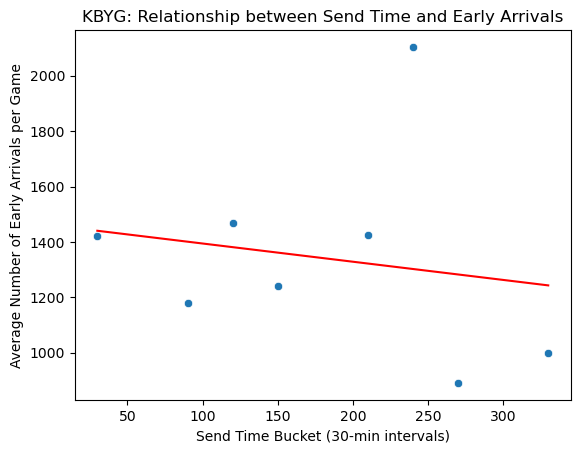

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Filter the data where send_time_bucket is less than 500
filtered_data = average_early_arrivals_per_game_by_send_time[average_early_arrivals_per_game_by_send_time['send_time_bucket'] < 10000]

# Plot the scatter plot
sns.scatterplot(data=filtered_data, x='send_time_bucket', y='early_arrival')

# Calculate the regression line
x = filtered_data['send_time_bucket']
y = filtered_data['early_arrival']
coefficients = np.polyfit(x, y, 1)
poly = np.poly1d(coefficients)
x_range = np.linspace(x.min(), x.max(), 100)
y_range = poly(x_range)

# Plot the regression line
plt.plot(x_range, y_range, color='red')

# Add labels and title
plt.xlabel('Send Time Bucket (30-min intervals)')
plt.ylabel('Average Number of Early Arrivals per Game')
plt.title('KBYG: Relationship between Send Time and Early Arrivals')

# Show the plot
plt.show()


In [8]:
df.columns

Index(['attendee_email', 'event_date', 'year', 'total_seats_sum_sum',
       'arrival_time_delta_avg', 'mobile_scans', 'scan_category_Bulls App',
       'scan_category_Other', 'scan_category_Text Message',
       'scan_category_Web Browser', 'scan_category_TM / LiveNation App',
       'ticketholder_attends', 'total_sends', 'total_delivered',
       'unique_opens', 'unique_clickthroughs_x', 'kbyg_min_sent_before',
       'post_min_sent_after', 'clickthrough_link_count',
       'unique_clickthroughs_y', 'kbyg_min_sent_before_ctrs',
       'post_min_sent_after_ctrs', 'kbyg_min_til_click', 'post_min_til_click',
       'clickthrough_url', 'gndr_input_indv_cd', 'age_two_yr_incr_input_indv',
       'adult_hh_num', 'presence_chldn_new_flg', 'income_est_hh_cd',
       'e3_spend_per_event'],
      dtype='object')

In [9]:
df['early_arrival'] = [True if x > 0 else False for x in df['arrival_time_delta_avg']]

In [13]:
df.groupby(['early_arrival']).agg({'e3_spend_per_event': 'mean'})

,e3_spend_per_event
early_arrival,
False,355.135153
True,380.353027


In [14]:
import scipy.stats as stats

# Split the data into two groups based on 'early_arrival'
early_arrival_group = df[df['early_arrival'] == True]['e3_spend_per_event'].dropna()
late_arrival_group = df[df['early_arrival'] == False]['e3_spend_per_event'].dropna()

# Perform the t-test
t_stat, p_value = stats.ttest_ind(early_arrival_group, late_arrival_group, equal_var=False)

# Print the results
print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: 8.626100508114492
P-value: 6.443112978086009e-18


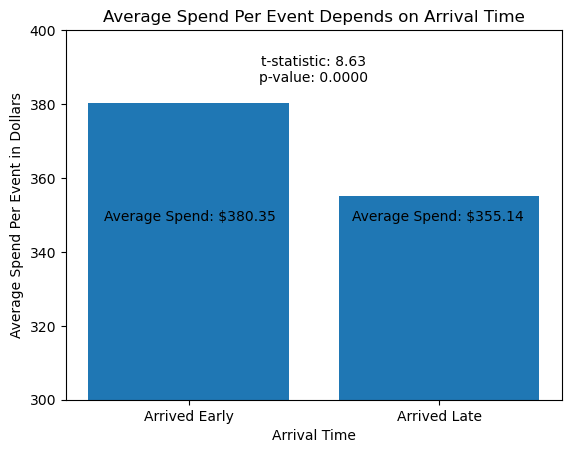

In [15]:
import matplotlib.pyplot as plt
import scipy.stats as stats

early_arrival_group = df[df['early_arrival'] == True]['e3_spend_per_event'].dropna()
late_arrival_group = df[df['early_arrival'] == False]['e3_spend_per_event'].dropna()

group1_mean = early_arrival_group.mean()
group2_mean = late_arrival_group.mean()

# Perform the t-test
t_stat, p_value = stats.ttest_ind(early_arrival_group, late_arrival_group, equal_var=False)

# Create a bar plot
fig, ax = plt.subplots()
ax.bar(['Arrived Early', 'Arrived Late'], [group1_mean, group2_mean], yerr=[stats.sem(df['e3_spend_per_event']), stats.sem(df['e3_spend_per_event'])], capsize=5)
ax.set_ylim(300, 400)

# Add labels and title
ax.set_xlabel('Arrival Time')
ax.set_ylabel('Average Spend Per Event in Dollars')
ax.set_title('Average Spend Per Event Depends on Arrival Time')

# Add text with t-test results
ax.text(0.5, 0.9, f't-statistic: {t_stat:.2f}\np-value: {p_value:.4f}', ha='center', va='center_baseline', transform=ax.transAxes)
ax.text(0.25, 0.5, f'Average Spend: ${group1_mean:.2f}', ha='center', va='center_baseline', transform=ax.transAxes)
ax.text(0.75, 0.5, f'Average Spend: ${group2_mean:.2f}', ha='center', va='center_baseline', transform=ax.transAxes)

# Show the plot
plt.show()


In [19]:
early_arrival_group.info()

<class 'pandas.core.series.Series'>
Index: 111270 entries, 1 to 209915
Series name: e3_spend_per_event
Non-Null Count   Dtype  
--------------   -----  
111270 non-null  float64
dtypes: float64(1)
memory usage: 1.7 MB


In [21]:
early_arrival_group_filtered = early_arrival_group[early_arrival_group < 500]
late_arrival_group_filtered = late_arrival_group[late_arrival_group < 500]


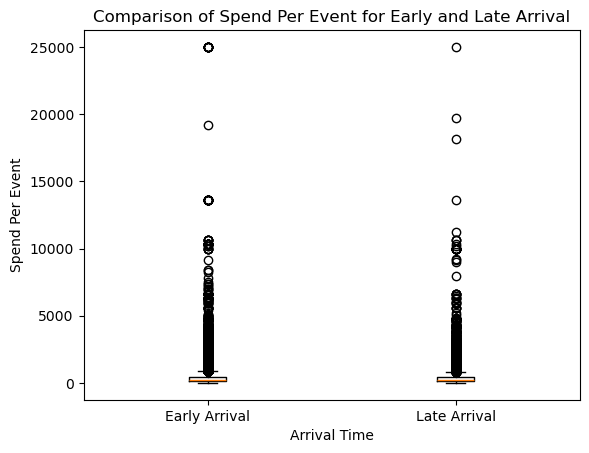

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Create box-and-whisker plots for early_arrival_group and late_arrival_group
ax.boxplot([early_arrival_group, late_arrival_group], labels=['Early Arrival', 'Late Arrival'])

# Add labels and title
ax.set_xlabel('Arrival Time')
ax.set_ylabel('Spend Per Event')
ax.set_title('Comparison of Spend Per Event for Early and Late Arrival')

# Show the plot
plt.show()

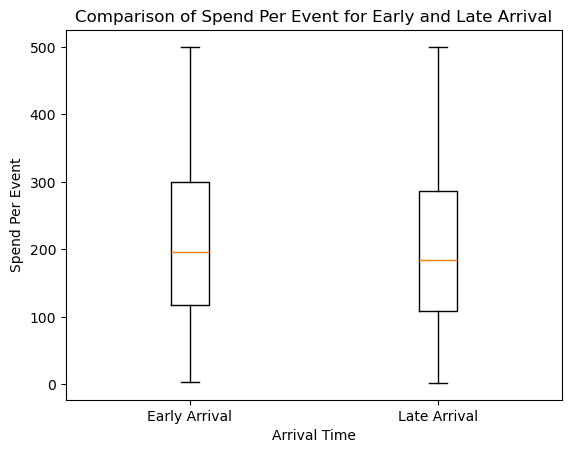

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Create box-and-whisker plots for early_arrival_group and late_arrival_group
ax.boxplot([early_arrival_group_filtered, late_arrival_group_filtered], labels=['Early Arrival', 'Late Arrival'])

# Add labels and title
ax.set_xlabel('Arrival Time')
ax.set_ylabel('Spend Per Event')
ax.set_title('Comparison of Spend Per Event for Early and Late Arrival')

# Show the plot
plt.show()


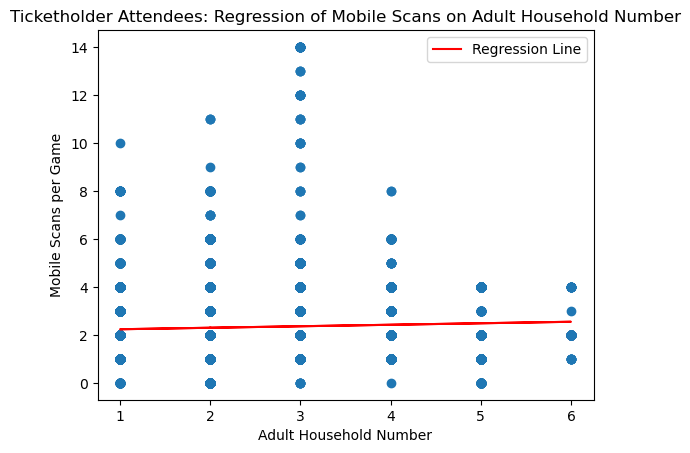

In [84]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Filter the data to include only rows where both columns are not NaN
filtered_data = df[df['ticketholder_attends'] == True]
filtered_data = filtered_data[['mobile_scans', 'adult_hh_num']].dropna()

# Perform the regression analysis
X = sm.add_constant(filtered_data['adult_hh_num'])
y = filtered_data['mobile_scans']
model = sm.OLS(y, X)
results = model.fit()

# Plot the relationship
plt.scatter(filtered_data['adult_hh_num'], filtered_data['mobile_scans'])
plt.plot(filtered_data['adult_hh_num'], results.fittedvalues, color='red', label='Regression Line')
plt.xlabel('Adult Household Number')
plt.ylabel('Mobile Scans per Game')
plt.title('Ticketholder Attendees: Regression of Mobile Scans on Adult Household Number')
plt.legend()
plt.show()


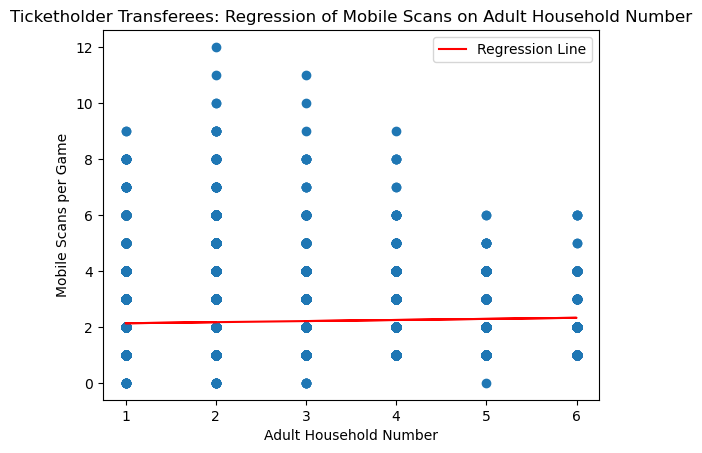

In [85]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Filter the data to include only rows where both columns are not NaN
filtered_data = df[df['ticketholder_attends'] == False]
filtered_data = filtered_data[['mobile_scans', 'adult_hh_num']].dropna()

# Perform the regression analysis
X = sm.add_constant(filtered_data['adult_hh_num'])
y = filtered_data['mobile_scans']
model = sm.OLS(y, X)
results = model.fit()

# Plot the relationship
plt.scatter(filtered_data['adult_hh_num'], filtered_data['mobile_scans'])
plt.plot(filtered_data['adult_hh_num'], results.fittedvalues, color='red', label='Regression Line')
plt.xlabel('Adult Household Number')
plt.ylabel('Mobile Scans per Game')
plt.title('Ticketholder Transferees: Regression of Mobile Scans on Adult Household Number')
plt.legend()
plt.show()


In [38]:
df.describe( include='all')

,attendee_email,event_date,total_seats_sum_sum,arrival_time_delta_avg_avg,mobile_scans_sum,scan_category_Bulls App,scan_category_Other,scan_category_Text Message,scan_category_Web Browser,scan_category_TM / LiveNation App,...,unique_clickthroughs_x,kbyg_min_sent_before,post_min_sent_after,clickthrough_link_count,unique_clickthroughs_y,kbyg_min_sent_before_ctrs,post_min_sent_after_ctrs,kbyg_min_til_click,post_min_til_click,clickthrough_url
count,209917,209917,209917.000000,198206.000000,209917.000000,209917.000000,209917.000000,209917.000000,209917.000000,209917.000000,...,121549.000000,120116.000000,7032.000000,3184.000000,3184.000000,2533.000000,673.000000,2533.000000,673.000000,3184
unique,116211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,295
top,andrewwaks1@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.nba.com/bulls/news/chicago-bulls-m...
freq,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,576
mean,NaN,2023-05-29 08:39:05.932916480,2.220116,24.203359,2.213299,0.521144,0.006817,0.007794,1.380369,0.303992,...,0.025726,167.239960,1079.215017,1.372487,1.371545,232.360837,1077.704309,1143.922258,572.523960,NaN
min,NaN,2022-10-04 00:00:00,1.000000,-140.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,60.000000,840.000000,1.000000,1.000000,60.000000,840.000000,0.000000,3.000000,NaN
25%,NaN,2022-12-28 00:00:00,2.000000,-1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,150.000000,960.000000,1.000000,1.000000,150.000000,960.000000,43.000000,46.000000,NaN
50%,NaN,2023-03-17 00:00:00,2.000000,20.500000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,180.000000,1020.000000,1.000000,1.000000,180.000000,1020.000000,78.000000,118.000000,NaN
75%,NaN,2023-12-02 00:00:00,2.000000,49.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,...,0.000000,180.000000,1020.000000,1.000000,1.000000,180.000000,1020.000000,156.000000,417.000000,NaN
max,NaN,2024-03-14 00:00:00,14.000000,440.000000,14.000000,14.000000,10.000000,10.000000,14.000000,9.000000,...,2.000000,360.000000,5670.000000,27.000000,26.000000,2820.000000,5670.000000,643809.000000,56269.000000,NaN


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209917 entries, 0 to 209916
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   attendee_email                     209917 non-null  object        
 1   event_date                         209917 non-null  datetime64[ns]
 2   total_seats_sum_sum                209917 non-null  int64         
 3   arrival_time_delta_avg_avg         198206 non-null  float64       
 4   mobile_scans_sum                   209917 non-null  float64       
 5   scan_category_Bulls App            209917 non-null  int64         
 6   scan_category_Other                209917 non-null  int64         
 7   scan_category_Text Message         209917 non-null  int64         
 8   scan_category_Web Browser          209917 non-null  int64         
 9   scan_category_TM / LiveNation App  209917 non-null  int64         
 10  ticketholder_attends

In [42]:
df_filtered = df.dropna(subset=['arrival_time_delta_avg_avg', 'kbyg_min_sent_before'])


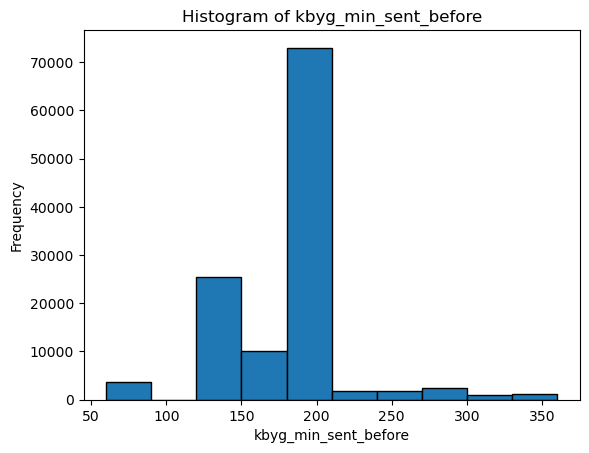

In [46]:
import matplotlib.pyplot as plt

# Filter out null values in the column
filtered_data = df_filtered["kbyg_min_sent_before"].dropna()

# Create the histogram
plt.hist(filtered_data, bins=10, edgecolor='black')

# Add labels and title
plt.xlabel("kbyg_min_sent_before")
plt.ylabel("Frequency")
plt.title("Histogram of kbyg_min_sent_before")

# Show the plot
plt.show()


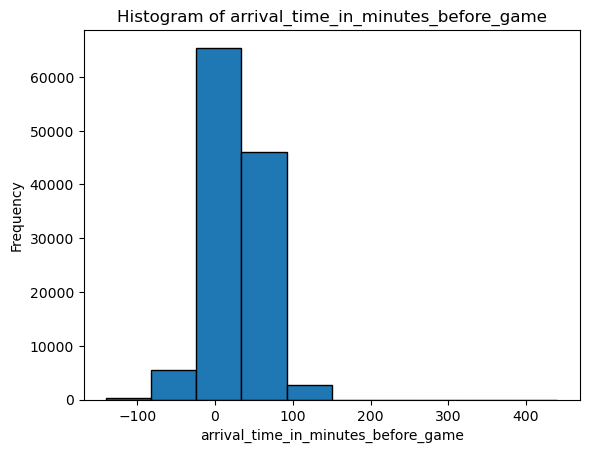

In [49]:
import matplotlib.pyplot as plt

# Filter out null values in the column
filtered_data = df_filtered['arrival_time_delta_avg_avg'].dropna()

# Create the histogram
plt.hist(filtered_data, bins=10, edgecolor='black')

# Add labels and title
plt.xlabel("arrival_time_in_minutes_before_game")
plt.ylabel("Frequency")
plt.title("Histogram of arrival_time_in_minutes_before_game")

# Show the plot
plt.show()

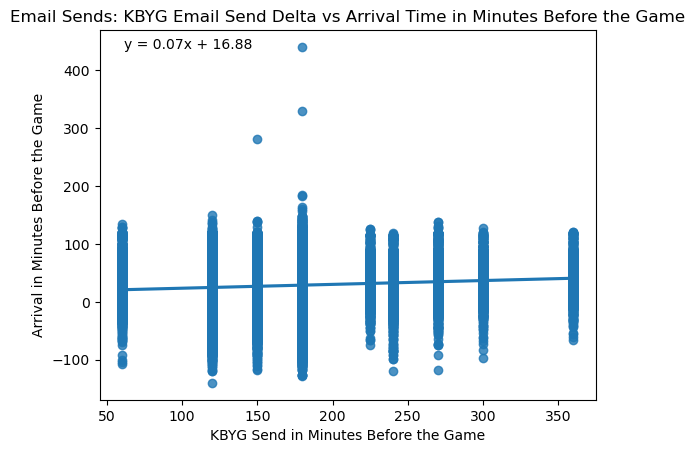

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Create a scatter plot with regression line
sns.regplot(data=df_filtered, y="arrival_time_delta_avg_avg", x="kbyg_min_sent_before")

# Calculate the regression line parameters
slope, intercept, r_value, p_value, std_err = stats.linregress(df_filtered['kbyg_min_sent_before'], df_filtered['arrival_time_delta_avg_avg'])

# Create the equation string
equation = f'y = {slope:.2f}x + {intercept:.2f}'

# Display the equation on the plot
plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes)

# Set plot title and labels
plt.title("Email Sends: KBYG Email Send Delta vs Arrival Time in Minutes Before the Game")
plt.xlabel("KBYG Send in Minutes Before the Game")
plt.ylabel("Arrival in Minutes Before the Game")

# Show the plot
plt.show()

In [51]:
df_filtered.columns

Index(['attendee_email', 'event_date', 'total_seats_sum_sum',
       'arrival_time_delta_avg_avg', 'mobile_scans_sum',
       'scan_category_Bulls App', 'scan_category_Other',
       'scan_category_Text Message', 'scan_category_Web Browser',
       'scan_category_TM / LiveNation App', 'ticketholder_attends',
       'total_sends', 'total_delivered', 'unique_opens',
       'unique_clickthroughs_x', 'kbyg_min_sent_before', 'post_min_sent_after',
       'clickthrough_link_count', 'unique_clickthroughs_y',
       'kbyg_min_sent_before_ctrs', 'post_min_sent_after_ctrs',
       'kbyg_min_til_click', 'post_min_til_click', 'clickthrough_url'],
      dtype='object')

In [59]:
df_filtered_opened = df_filtered[~df_filtered['unique_opens'].isna()]

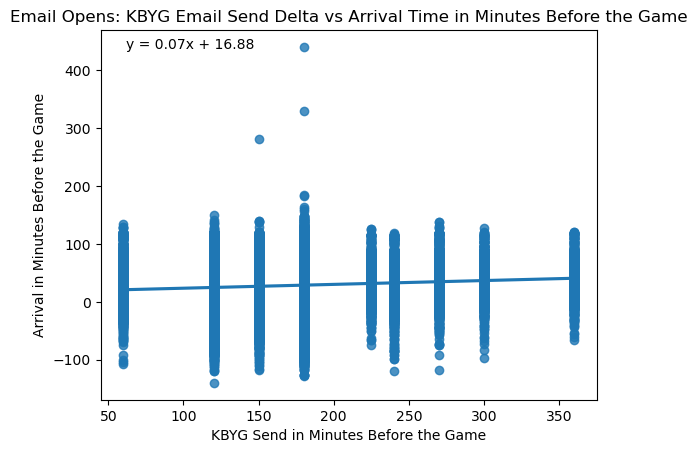

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Create a scatter plot with regression line
sns.regplot(data=df_filtered_opened, y="arrival_time_delta_avg_avg", x="kbyg_min_sent_before")

# Calculate the regression line parameters
slope, intercept, r_value, p_value, std_err = stats.linregress(df_filtered_opened['kbyg_min_sent_before'], df_filtered_opened['arrival_time_delta_avg_avg'])

# Create the equation string
equation = f'y = {slope:.2f}x + {intercept:.2f}'

# Display the equation on the plot
plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes)

# Set plot title and labels
plt.title("Email Opens: KBYG Email Send Delta vs Arrival Time in Minutes Before the Game")
plt.xlabel("KBYG Send in Minutes Before the Game")
plt.ylabel("Arrival in Minutes Before the Game")

# Show the plot
plt.show()

In [52]:
df_filtered_clicked = df_filtered[~df_filtered['unique_clickthroughs_y'].isna()]

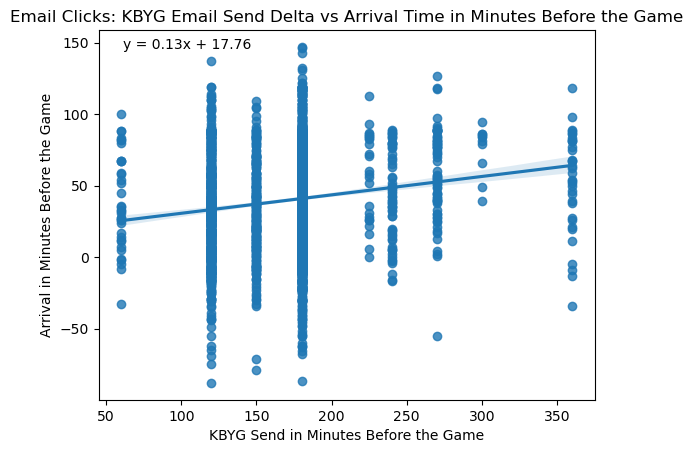

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Create a scatter plot with regression line
sns.regplot(data=df_filtered_clicked, y="arrival_time_delta_avg_avg", x="kbyg_min_sent_before")

# Calculate the regression line parameters
slope, intercept, r_value, p_value, std_err = stats.linregress(df_filtered_clicked['kbyg_min_sent_before'], df_filtered_clicked['arrival_time_delta_avg_avg'])

# Create the equation string
equation = f'y = {slope:.2f}x + {intercept:.2f}'

# Display the equation on the plot
plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes)

# Set plot title and labels
plt.title("Email Clicks: KBYG Email Send Delta vs Arrival Time in Minutes Before the Game")
plt.xlabel("KBYG Send in Minutes Before the Game")
plt.ylabel("Arrival in Minutes Before the Game")

# Show the plot
plt.show()

In [132]:
df.columns

Index(['attendee_email', 'event_date', 'year', 'total_seats_sum_sum',
       'arrival_time_delta_avg', 'mobile_scans', 'scan_category_Bulls App',
       'scan_category_Other', 'scan_category_Text Message',
       'scan_category_Web Browser', 'scan_category_TM / LiveNation App',
       'ticketholder_attends', 'total_sends', 'total_delivered',
       'unique_opens', 'unique_clickthroughs_x', 'kbyg_min_sent_before',
       'post_min_sent_after', 'clickthrough_link_count',
       'unique_clickthroughs_y', 'kbyg_min_sent_before_ctrs',
       'post_min_sent_after_ctrs', 'kbyg_min_til_click', 'post_min_til_click',
       'clickthrough_url', 'gndr_input_indv_cd', 'age_two_yr_incr_input_indv',
       'adult_hh_num', 'presence_chldn_new_flg', 'income_est_hh_cd',
       'e3_spend_per_event'],
      dtype='object')

In [129]:
df.groupby(['ticketholder_attends', 'email_type'])['unique_clickthroughs_y'].sum()

KeyError: 'email_type'

In [126]:
df.groupby(['ticketholder_attends']).count()

,attendee_email,event_date,year,total_seats_sum_sum,arrival_time_delta_avg,mobile_scans,scan_category_Bulls App,scan_category_Other,scan_category_Text Message,scan_category_Web Browser,...,post_min_sent_after_ctrs,kbyg_min_til_click,post_min_til_click,clickthrough_url,gndr_input_indv_cd,age_two_yr_incr_input_indv,adult_hh_num,presence_chldn_new_flg,income_est_hh_cd,e3_spend_per_event
ticketholder_attends,,,,,,,,,,,,,,,,,,,,,
0,158163,158163,158163,158163,148585,158163,158163,158163,158163,158163,...,375,1946,375,2306,105074,102049,108972,69476,101698,113316
1,51754,51754,51754,51754,49621,51754,51754,51754,51754,51754,...,298,587,298,878,43862,43568,46011,30189,43941,44365


In [127]:
3127/158163

0.019770742841246056

In [128]:
1240/51754

0.023959500714920586

In [118]:
df.groupby(['event_date', 'opponent_short']).agg({'attendee_email': 'nunique'})

KeyError: 'opponent_short'

In [110]:
xx = df.groupby(['attendee_email', 'event_date']).agg({"arrival_time_delta_avg": "mean", "e3_spend_per_event": "mean", "ticketholder_attends":'first'}).reset_index()

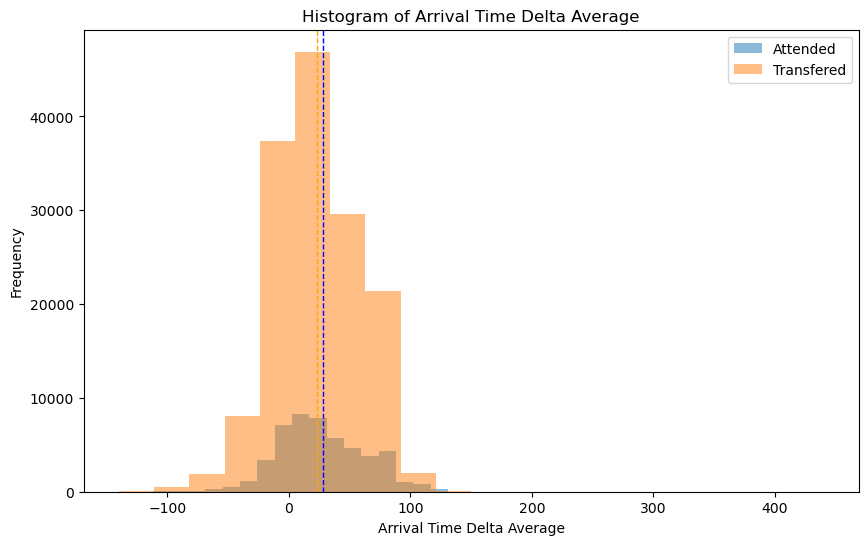

In [115]:
import matplotlib.pyplot as plt

# Filter the data based on ticketholder_attends
attended = xx[xx['ticketholder_attends'] == 1]
not_attended = xx[xx['ticketholder_attends'] == 0]

# Plotting the histograms
plt.figure(figsize=(10, 6))

# Histogram for attended ticketholders
plt.hist(attended['arrival_time_delta_avg'], bins=20, alpha=0.5, label='Attended')
# Draw a vertical line at the mean of the attended distribution
plt.axvline(attended['arrival_time_delta_avg'].mean(), color='blue', linestyle='dashed', linewidth=1)

# Histogram for not attended ticketholders
plt.hist(not_attended['arrival_time_delta_avg'], bins=20, alpha=0.5, label='Transfered')
# Draw a vertical line at the mean of the not attended distribution
plt.axvline(not_attended['arrival_time_delta_avg'].mean(), color='orange', linestyle='dashed', linewidth=1)

plt.xlabel('Arrival Time Delta Average')
plt.ylabel('Frequency')
plt.title('Histogram of Arrival Time Delta Average')
plt.legend()

plt.show()


In [114]:
from scipy import stats

# Filter the data based on ticketholder_attends
attended = xx[xx['ticketholder_attends'] == 1]['arrival_time_delta_avg']
not_attended = xx[xx['ticketholder_attends'] == 0]['arrival_time_delta_avg']

# Perform t-test
t_stat, p_value = stats.ttest_ind(attended, not_attended)

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

T-statistic: nan
P-value: nan


In [111]:
ogs = df[df['ticketholder_attends'] == True]
transferees = df[df['ticketholder_attends'] == False]

,attendee_email,event_date,arrival_time_delta_avg,e3_spend_per_event,ticketholder_attends
0,000liviacanny@gmail.com,2024-02-22 00:00:00+00:00,22.0,210.0,0
1,002juneau@gmail.com,2024-01-05 00:00:00+00:00,21.0,172.0,0
2,00JesseG@gmail.com,2022-10-11 00:00:00+00:00,NaN,NaN,0
3,00tony1906@gmail.com,2022-12-28 00:00:00+00:00,48.0,NaN,0
4,01.infirm-pedants@icloud.com,2023-02-13 00:00:00+00:00,-7.0,NaN,0


In [101]:
kbyg.columns

Index(['attendee_email', 'event_date', 'year', 'total_seats_sum_sum',
       'arrival_time_delta_avg', 'mobile_scans', 'scan_category_Bulls App',
       'scan_category_Other', 'scan_category_Text Message',
       'scan_category_Web Browser', 'scan_category_TM / LiveNation App',
       'ticketholder_attends', 'total_sends', 'total_delivered',
       'unique_opens', 'unique_clickthroughs_x', 'kbyg_min_sent_before',
       'post_min_sent_after', 'clickthrough_link_count',
       'unique_clickthroughs_y', 'kbyg_min_sent_before_ctrs',
       'post_min_sent_after_ctrs', 'kbyg_min_til_click', 'post_min_til_click',
       'clickthrough_url', 'gndr_input_indv_cd', 'age_two_yr_incr_input_indv',
       'adult_hh_num', 'presence_chldn_new_flg', 'income_est_hh_cd',
       'e3_spend_per_event'],
      dtype='object')

In [99]:
len(df)

209917

In [100]:
kbyg = df[~df['kbyg_min_sent_before'].isna()]

In [94]:
len(kbyg)

120116

In [102]:
kbyg_filtered = kbyg.dropna(subset=['arrival_time_delta_avg', 'e3_spend_per_event'])


In [103]:
len(kbyg_filtered)

93261

In [107]:
kbyg_filtered[['arrival_time_delta_avg', 'e3_spend_per_event']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 93261 entries, 1 to 209912
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   arrival_time_delta_avg  93261 non-null  float64
 1   e3_spend_per_event      93261 non-null  float64
dtypes: float64(2)
memory usage: 2.1 MB


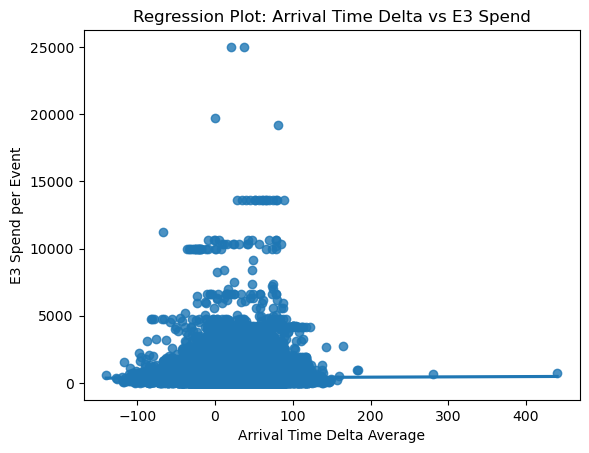

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the variables for regression
x = kbyg_filtered['arrival_time_delta_avg']
y = kbyg_filtered['e3_spend_per_event']

# Plot the regression
sns.regplot(x=x, y=y)
plt.xlabel('Arrival Time Delta Average')
plt.ylabel('E3 Spend per Event')
plt.title('Regression Plot: Arrival Time Delta vs E3 Spend')
plt.show()


In [ ]:
ogs = df[df['ticketholder_attends'] == True]

In [15]:
transferees = df[df['ticketholder_attends'] == False]

In [25]:
# Assuming df is your DataFrame and 'col1' and 'col2' are the columns
trans_got_kbyg = transferees[~transferees['kbyg_min_sent_before'].isna()]
trans_kbyg_but_no_post = trans_got_kbyg[trans_got_kbyg['post_min_sent_after'].isna()]

# Count the number of True values
count = len(trans_kbyg_but_no_post)

print(count/len(trans_got_kbyg))

0.9526765967651682


In [26]:
# Use melt to pivot the columns
df_melted = transferees.melt(var_name='email_type', value_name='send_delta_min')

# Replace the prefixes in the 'prefix' column
df_melted['email_type'] = df_melted['email_type'].str.replace('_min_sent_before', '').str.replace('_min_sent_after', '')

df_melted.head()

,email_type,send_delta_min
0,kbyg,180.0
1,kbyg,NaN
2,kbyg,NaN
3,kbyg,NaN
4,kbyg,NaN


In [27]:
import pandas as pd

# Create a DataFrame
df = pd.DataFrame({
    'A': ['foo', 'foo', 'foo', 'bar', 'bar', 'bar'],
    'B': ['one', 'one', 'two', 'two', 'one', 'one'],
    'C': ['small', 'large', 'large', 'small', 'small', 'large'],
    'D': [1, 2, 2, 3, 3, 4],
    'E': [2, 4, 5, 5, 6, 6]
})

# Melt the DataFrame
melted_df = df.melt(id_vars=['A', 'B'], value_vars=['D', 'E'])

print(melted_df)

      A    B variable  value
0   foo  one        D      1
1   foo  one        D      2
2   foo  two        D      2
3   bar  two        D      3
4   bar  one        D      3
5   bar  one        D      4
6   foo  one        E      2
7   foo  one        E      4
8   foo  two        E      5
9   bar  two        E      5
10  bar  one        E      6
11  bar  one        E      6


In [14]:
df[[
    'total_seats_sum_sum', 'arrival_time_delta_avg_avg', 'mobile_scans_sum',
    'scan_category_Bulls App', 'scan_category_Other', 'scan_category_Text Message', 'scan_category_Web Browser', 'scan_category_TM / LiveNation App', 
    'ticketholder_attends',
    'kbyg_min_sent_before', 'post_min_sent_after',
    'kbyg_min_sent_before_ctrs', 'post_min_sent_after_ctrs',
    ]]

,total_seats_sum_sum,arrival_time_delta_avg_avg,mobile_scans_sum,scan_category_Bulls App,scan_category_Other,scan_category_Text Message,scan_category_Web Browser,scan_category_TM / LiveNation App,ticketholder_attends,kbyg_min_sent_before,post_min_sent_after,kbyg_min_sent_before_ctrs,post_min_sent_after_ctrs
0,2,31.500000,2.0,0,0,0,2,0,1,180.0,NaN,NaN,NaN
1,1,115.000000,1.0,1,0,0,0,0,1,180.0,NaN,NaN,NaN
2,1,63.000000,1.0,1,0,0,0,0,1,180.0,NaN,NaN,NaN
3,2,62.000000,2.0,2,0,0,0,0,1,NaN,NaN,NaN,NaN
4,6,19.333333,6.0,0,0,0,6,0,1,120.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209912,2,70.000000,2.0,0,0,0,2,0,0,180.0,NaN,NaN,NaN
209913,2,2.000000,2.0,0,0,0,2,0,0,NaN,NaN,NaN,NaN
209914,2,-27.000000,2.0,2,0,0,0,0,0,NaN,NaN,NaN,NaN
209915,3,62.000000,3.0,0,0,0,3,0,0,NaN,NaN,NaN,NaN


In [13]:
import statsmodels.api as sm

# Define the predictor variables
X = df[[
    'total_seats_sum_sum', 'arrival_time_delta_avg_avg', 'mobile_scans_sum',
    'scan_category_Bulls App', 'scan_category_Other', 'scan_category_Text Message', 'scan_category_Web Browser', 'scan_category_TM / LiveNation App', 
    'ticketholder_attends',
    'kbyg_min_sent_before', 'post_min_sent_after',
    'kbyg_min_sent_before_ctrs', 'post_min_sent_after_ctrs',
    ]]

# Add a constant column to the predictor variables
X = sm.add_constant(X)

# Define the response variable
y = df['unique_clickthroughs_y']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())


MissingDataError: exog contains inf or nans

In [29]:
xx = df[~df['clickthrough_url'].isnull()]
sum(xx['unique_clickthroughs_x'] <= xx['unique_clickthroughs_y'])/len(xx)

0.9993718592964824

In [26]:
len(xx)

3184

In [27]:
xx

,attendee_email,event_date,total_seats_sum_sum,arrival_time_delta_avg_avg,mobile_scans_sum,scan_category_Bulls App,scan_category_Other,scan_category_Text Message,scan_category_Web Browser,scan_category_TM / LiveNation App,...,unique_clickthroughs_x,kbyg_min_sent_before,post_min_sent_after,clickthrough_link_count,unique_clickthroughs_y,kbyg_min_sent_before_ctrs,post_min_sent_after_ctrs,kbyg_min_til_click,post_min_til_click,clickthrough_url
49,jonathan.e.lee@gmail.com,2023-02-06,2,0.0,2.0,2,0,0,0,0,...,1.0,180.0,NaN,1.0,1.0,180.0,NaN,36.0,NaN,https://www.nba.com/bulls/amex
169,dwashingth@aol.com,2023-03-22,2,-16.5,2.0,2,0,0,0,0,...,1.0,180.0,960.0,1.0,1.0,NaN,960.0,NaN,51.0,https://bulls.qualtrics.com/jfe/form/SV_cNsSkl...
170,cjglenn@sbcglobal.net,2024-03-11,2,19.0,2.0,2,0,0,0,0,...,1.0,180.0,NaN,1.0,1.0,180.0,NaN,79.0,NaN,https://www.nba.com/bulls/playerjerseyseries
257,jcjcmj75@aol.com,2022-12-31,2,49.0,2.0,2,0,0,0,0,...,1.0,240.0,NaN,1.0,1.0,240.0,NaN,15.0,NaN,https://www.nba.com/bulls/amex
357,mistershop@aol.com,2023-04-02,2,-6.0,2.0,2,0,0,0,0,...,1.0,150.0,NaN,1.0,1.0,150.0,NaN,98.0,NaN,https://www.unitedcenter.com/venue/dining/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209433,wschuman@mwe.com,2023-03-22,2,80.0,2.0,0,0,0,2,0,...,1.0,180.0,960.0,1.0,1.0,NaN,960.0,NaN,260.0,https://bulls.qualtrics.com/jfe/form/SV_cNsSkl...
209546,sanruck@yahoo.com,2022-10-22,3,69.0,3.0,0,0,0,3,0,...,1.0,180.0,NaN,1.0,1.0,180.0,NaN,63.0,NaN,https://madhouseteamstore.com/
209684,jwalsh2@gmail.com,2023-03-15,2,89.0,2.0,0,0,0,0,2,...,1.0,180.0,NaN,1.0,1.0,180.0,NaN,22.0,NaN,https://www.nba.com/bulls/news/chicago-bulls-m...
209844,jw7227@yahoo.com,2023-01-31,1,53.0,1.0,0,0,0,1,0,...,1.0,180.0,NaN,1.0,1.0,180.0,NaN,37.0,NaN,https://www.nba.com/bulls/healthandsafety
